# Importing Dependancies

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')

from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem     import WordNetLemmatizer

import re
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection         import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anishghiya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


! pip install bs4 # in case you don't have it installed

Dataset: https://web.archive.org/web/20201127142707if_/https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Office_Products_v1_00.tsv.gz

# 1. Dataset Preparation
## (i) Read the data as a Pandas frame using Pandas package

In [2]:
df = pd.read_csv("data.tsv", sep="\t", error_bad_lines=False)

Skipping line 20773: expected 15 fields, saw 22
Skipping line 39834: expected 15 fields, saw 22
Skipping line 52957: expected 15 fields, saw 22
Skipping line 54540: expected 15 fields, saw 22

Skipping line 80276: expected 15 fields, saw 22
Skipping line 96168: expected 15 fields, saw 22
Skipping line 96866: expected 15 fields, saw 22
Skipping line 98175: expected 15 fields, saw 22
Skipping line 112539: expected 15 fields, saw 22
Skipping line 119377: expected 15 fields, saw 22
Skipping line 120065: expected 15 fields, saw 22
Skipping line 124703: expected 15 fields, saw 22

Skipping line 134024: expected 15 fields, saw 22
Skipping line 153938: expected 15 fields, saw 22
Skipping line 156225: expected 15 fields, saw 22
Skipping line 168603: expected 15 fields, saw 22
Skipping line 187002: expected 15 fields, saw 22

Skipping line 200397: expected 15 fields, saw 22
Skipping line 203809: expected 15 fields, saw 22
Skipping line 207680: expected 15 fields, saw 22
Skipping line 223421: exp

In [3]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,43081963,R18RVCKGH1SSI9,B001BM2MAC,307809868,"Scotch Cushion Wrap 7961, 12 Inches x 100 Feet",Office Products,5,0.0,0.0,N,Y,Five Stars,Great product.,2015-08-31
1,US,10951564,R3L4L6LW1PUOFY,B00DZYEXPQ,75004341,"Dust-Off Compressed Gas Duster, Pack of 4",Office Products,5,0.0,1.0,N,Y,"Phffffffft, Phfffffft. Lots of air, and it's C...",What's to say about this commodity item except...,2015-08-31
2,US,21143145,R2J8AWXWTDX2TF,B00RTMUHDW,529689027,Amram Tagger Standard Tag Attaching Tagging Gu...,Office Products,5,0.0,0.0,N,Y,but I am sure I will like it.,"Haven't used yet, but I am sure I will like it.",2015-08-31
3,US,52782374,R1PR37BR7G3M6A,B00D7H8XB6,868449945,AmazonBasics 12-Sheet High-Security Micro-Cut ...,Office Products,1,2.0,3.0,N,Y,and the shredder was dirty and the bin was par...,Although this was labeled as &#34;new&#34; the...,2015-08-31
4,US,24045652,R3BDDDZMZBZDPU,B001XCWP34,33521401,"Derwent Colored Pencils, Inktense Ink Pencils,...",Office Products,4,0.0,0.0,N,Y,Four Stars,Gorgeous colors and easy to use,2015-08-31


## (ii) Only keep the Reviews and Ratings fields in the input data frame to generate data.

In [4]:
#Extracting Reviews and ratings
df_subset =  df[['review_headline', 'review_body', 'star_rating']]
print(f"The unique values in the Star Rating column are: {df.star_rating.unique()}")

#Removing the date values from the above as they are false instances
df_clean = df_subset[~df_subset['star_rating'].isin(["2015-06-05", "2015-02-11", "2014-02-14"])]
print(f"Number of NA values is: {df_clean.star_rating.isna().sum()}")

#Converting StarRatings as Integer and dropping rows with NA Values
df_clean.dropna(inplace=True)
df_clean['star_rating'] = df_clean['star_rating'].astype("int")
print(f"After Cleaning the unique values in the Star Rating Column are: {df_clean.star_rating.unique()}")

The unique values in the Star Rating column are: [5 1 4 2 3 '5' '4' '3' '1' '2' '2015-06-05' '2015-02-11' nan '2014-02-14']
Number of NA values is: 14
After Cleaning the unique values in the Star Rating Column are: [5 1 4 2 3]


## (iii) We create a binary classification problem according to the ratings. Let ratings with the values of 1, 2 and 3 form class 1, and ratings with the values of 4 and 5 form class 2

In [5]:
# Create a new column 'new_class' based on 'star_rating' values
# Assign 2 to rows where 'star_rating' is greater than 3 (representing positive sentiment)
df_clean.loc[df_clean['star_rating'] > 3, 'new_class'] = 2

# Assign 1 to rows where 'star_rating' is 3 or lower (representing negative sentiment)
df_clean.loc[df_clean['star_rating'] <= 3, 'new_class'] = 1

# Convert the 'new_class' column to integers for consistency
df_clean['new_class'] = df_clean['new_class'].astype(int)

# Drop the original 'star_rating' column as it's no longer needed
df_clean.drop('star_rating', axis=1, inplace=True)
df_clean.head()

,review_headline,review_body,new_class
0,Five Stars,Great product.,2
1,"Phffffffft, Phfffffft. Lots of air, and it's C...",What's to say about this commodity item except...,2
2,but I am sure I will like it.,"Haven't used yet, but I am sure I will like it.",2
3,and the shredder was dirty and the bin was par...,Although this was labeled as &#34;new&#34; the...,1
4,Four Stars,Gorgeous colors and easy to use,2


In [6]:
df_clean['new_class'].value_counts()

2    2001098
1     639030
Name: new_class, dtype: int64

## (iv) The original dataset is large. To avoid the computational burden, select 50,000 random reviews from each rating class and create a balanced dataset to perform the required tasks on the downsized dataset

In [7]:
# Define the number of samples to select per class (equal for both classes)
num_samples_per_class = 50000

# Get the indices of rows belonging to class 1 (negative sentiment) and class 2 (positive sentiment)
class_1_indices = df_clean[df_clean['new_class'] == 1].index
class_2_indices = df_clean[df_clean['new_class'] == 2].index

# Randomly sample 'num_samples_per_class' indices from each class with a fixed random seed (for reproducibility)
selected_indices = (
    class_1_indices.to_series().sample(num_samples_per_class, random_state=42)
    .append(class_2_indices.to_series().sample(num_samples_per_class, random_state=42))
)

# Create a new DataFrame 'df_50k' containing the selected samples from both classes
df_50k = df_clean.loc[selected_indices]

# df_50k, _ = train_test_split(df_clean, train_size=50000, stratify=df_clean['new_class'], random_state=42)

In [8]:
print(f"Original dimensions: {df_clean.shape}, \nAfter extracting 50000 rows: {df_50k.shape}")

Original dimensions: (2640128, 3), 
After extracting 50000 rows: (100000, 3)


In [9]:
df_50k['new_class'].value_counts()

1    50000
2    50000
Name: new_class, dtype: int64

# 2. Data Cleaning

In [10]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mm" : "milimeter",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [11]:
class TextPreprocessor:
    def __init__(self):
        pass
    
    @staticmethod
    def lower_case(text):
        return text.lower()

    @staticmethod
    def remove_html(text):
        html = re.compile(r'<.*?>')
        return html.sub(r'', text)

    @staticmethod
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        x = re.findall(url, text)
        if x != []:
            x = x[0]
        else:
            x = ''
        return text.replace(x, '')
    
    @staticmethod
    def remove_non_alphabet(text):
        words = []
        for word in text.split():
            words.append(re.sub("[^A-Za-z]", "", word))
        return " ".join(words)

    @staticmethod
    def remove_spaces(text):
        text = text.strip().split()
        text = " ".join(text)
        return text
    
    @staticmethod
    def convert_abbrev(text):
        sent=[]
        for word in text.split(" "):
            if word in abbreviations.keys():
                sent.append(abbreviations[word])
            else :
                sent.append(word)
        return " ".join(sent)
    
    
    def preprocess(self, text):
        text = self.lower_case(text)
        text = self.remove_html(text)
        text = self.remove_URL(text)
        text = self.remove_non_alphabet(text)
        text = self.remove_spaces(text)
        text = self.convert_abbrev(text)
        return text

# Creating an instance of the TextPreprocessor class
preprocessor = TextPreprocessor()

# Assuming 'df_50k' is your DataFrame
df_50k['review_body_cleaned'] = df_50k['review_body'].apply(preprocessor.preprocess)

In [12]:
df_50k.head()

,review_headline,review_body,new_class,review_body_cleaned
1681909,Poor quality for an item that was costly.,Last school year I purchased it for my daughte...,1,last school year i purchased it for my daughte...
2127992,Ripped after 1 DAY of use!!!!,If you are thinking of purchasing this product...,1,if you are thinking of purchasing this product...
1113938,nothing special but they work,"These are very thin, but they serve the purpose.",1,these are very thin but they serve the purpose
1477157,bought 2 mighty bright,The first one kept going off Put in new batter...,1,the first one kept going off put in new batter...
1700525,Doesnt Print correctly,"I must of used this printer 4 or 5 time, the p...",1,i must of used this printer or time the printe...


In [13]:
avg_length_before = df_50k['review_body'].apply(len).mean()
avg_length_after = df_50k['review_body_cleaned'].apply(len).mean()

# Print the results
print(f"Average length of reviews before cleaning: {avg_length_before:.2f} characters")
print(f"Average length of reviews after cleaning: {avg_length_after:.2f} characters")
# print(f"{avg_length_before:.2f}, {avg_length_after:.2f}")

Average length of reviews before cleaning: 317.60 characters
Average length of reviews after cleaning: 300.86 characters


In [14]:
def get_review_length(text):
    return len(word_tokenize(text))
df_50k['review_body_length']=df_50k['review_body'].apply(lambda x: get_review_length(x))
df_50k['review_body_cleaned_length']=df_50k['review_body_cleaned'].apply(lambda x: get_review_length(x))

In [15]:
print(f"Average length of reviews before cleaning: {df_50k[['review_body_length', 'review_body_cleaned_length']].describe().iloc[1].values[0]} words")
print(f"Average length of reviews after cleaning: {df_50k[['review_body_length', 'review_body_cleaned_length']].describe().iloc[1].values[1]} words")


Average length of reviews before cleaning: 68.97108 words
Average length of reviews after cleaning: 57.03143 words


# 3. Preprocessing
## (i) Remove the stop words

In [16]:
stop_wds = stopwords.words('english')
def remove_stop_wds(text):
    l=[]
    text = word_tokenize(text)
    for word in text:
        if word not in stop_wds:
            l.append(word)
    return " ".join(l)

df_50k['review_body_stopwds_processed']=df_50k['review_body_cleaned'].apply(lambda x: remove_stop_wds(x))

In [17]:
avg_length_nopreprocessing = df_50k['review_body'].apply(len).mean()
avg_length_clean = df_50k['review_body_cleaned'].apply(len).mean()
avg_length_clean_stpwds = df_50k['review_body_stopwds_processed'].apply(len).mean()

# Print the results
print(f"Average length of reviews before any processing: {avg_length_nopreprocessing:.2f} characters")
print(f"Average length of reviews after cleaning: {avg_length_clean:.2f} characters")
print(f"Average length of reviews after cleaning and stemming: {avg_length_clean_stpwds:.2f} characters")

Average length of reviews before any processing: 317.60 characters
Average length of reviews after cleaning: 300.86 characters
Average length of reviews after cleaning and stemming: 194.60 characters


## (ii) Perform lemmatization

In [29]:
lemmatizer = WordNetLemmatizer()
def lemmatize_wds(text):
    l=[]
    text = word_tokenize(text)
    for word in text:
        worded = lemmatizer.lemmatize(word, pos='v')
        l.append(word)
    return " ".join(l)

df_50k['review_body_lemm_processed']=df_50k['review_body_stopwds_processed'].apply(lambda x: lemmatize_wds(x))

In [30]:
avg_length_nopreprocessing = df_50k['review_body'].apply(len).mean()
avg_length_clean = df_50k['review_body_cleaned'].apply(len).mean()
avg_length_clean_stpwds = df_50k['review_body_stopwds_processed'].apply(len).mean()
avg_length_clean_lemm = df_50k['review_body_lemm_processed'].apply(len).mean()

# Print the results
print(f"Average length of reviews before any processing: {avg_length_nopreprocessing:.2f} characters")
print(f"Average length of reviews after cleaning: {avg_length_clean:.2f} characters")
print(f"Average length of reviews after cleaning and stemming: {avg_length_clean_stpwds:.2f} characters")
print(f"Average length of reviews after cleaning and stemming and lemmetizing: {avg_length_clean_lemm:.2f} characters")

Average length of reviews before any processing: 317.60 characters
Average length of reviews after cleaning: 300.86 characters
Average length of reviews after cleaning and stemming: 194.60 characters
Average length of reviews after cleaning and stemming and lemmetizing: 194.60 characters


In [31]:
df_50k['review_body_length']=df_50k['review_body'].apply(lambda x: get_review_length(x))
df_50k['review_body_cleaned_length']=df_50k['review_body_cleaned'].apply(lambda x: get_review_length(x))
df_50k['review_body_stopwds_processed_length']=df_50k['review_body_stopwds_processed'].apply(lambda x: get_review_length(x))
df_50k['review_body_lemm_processed_length']=df_50k['review_body_lemm_processed'].apply(lambda x: get_review_length(x))
df_50k[["review_body_length", "review_body_cleaned_length", "review_body_lemm_processed_length"]].describe().iloc[1]

review_body_length                   68.97108
review_body_cleaned_length           57.03143
review_body_lemm_processed_length    28.81422
Name: mean, dtype: float64

In [32]:
print(f"Average length of reviews before processing: {df_50k[['review_body_length', 'review_body_cleaned_length', 'review_body_lemm_processed_length']].describe().iloc[1].values[0]}")
print(f"Average length of reviews after cleaning: {df_50k[['review_body_length', 'review_body_cleaned_length', 'review_body_lemm_processed_length']].describe().iloc[1].values[1]}")
print(f"Average length of reviews after stemming and lemmatization: {df_50k[['review_body_length', 'review_body_cleaned_length', 'review_body_lemm_processed_length']].describe().iloc[1].values[2]}")


Average length of reviews before processing: 68.97108
Average length of reviews after cleaning: 57.03143
Average length of reviews after stemming and lemmatization: 28.81422


# 4. Feature Extraction
## (i) Bag of Words

In [33]:
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df_50k['review_body_lemm_processed'])

## (ii) TF-IDF

In [34]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_50k['review_body_lemm_processed'])

## (iii) Train Test Split

In [35]:
y = df_50k['new_class']
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [36]:
def train_funct(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    
    precision = precision_score(y_test, y_hat, average="weighted")
    recall = recall_score(y_test, y_hat, average="weighted")
    f1 = f1_score(y_test, y_hat, average="weighted")
    
    # Get the confusion matrix
    cm = confusion_matrix(y_test, y_hat)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Get the classification report
    class_report = classification_report(y_test, y_hat)
    
    # Print the classification report
    print("Classification Report:")
    print(class_report)
    
    return precision, recall, f1

def get_results_df(clf, 
                   precision_tfidf, recall_tfidf, f1_tfidf, 
                   precision_bow, recall_bow, f1_bow):
    
    model_name = type(clf).__name__
    data = {
        'Algorithm': [model_name, model_name],
        'Approach': ['BoW', 'TF-IDF'],
        'Precision': [precision_bow, precision_tfidf],
        'Recall': [recall_bow, recall_tfidf],
        'F1-Score': [f1_bow, f1_tfidf]
    }
    
    results_df = pd.DataFrame(data)
    print([" ".join(map(str, v[2:])) for v in results_df.values][0])
    print([" ".join(map(str, v[2:])) for v in results_df.values][1])
    
    return results_df


# 5. Perceptron

## (i)TF-IDF

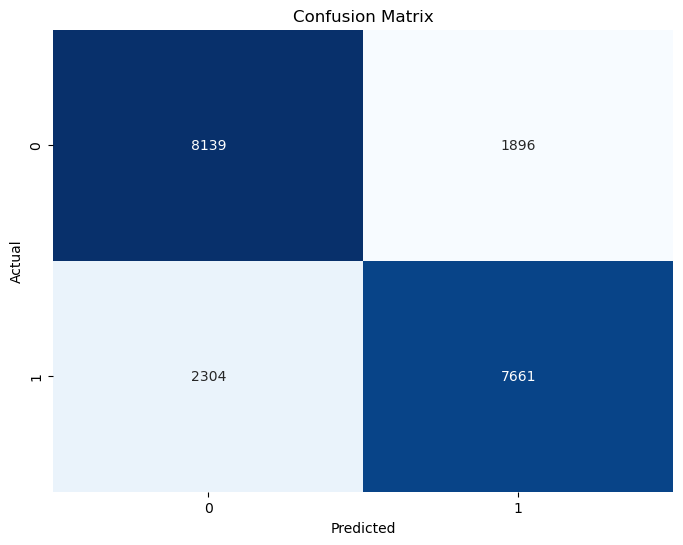

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.81      0.79     10035
           2       0.80      0.77      0.78      9965

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



In [37]:
clf_perceptron = Perceptron(tol=1e-3, random_state=0)
precision_perceptron_tfidf, recall_perceptron_tfidf, f1_perceptron_tfidf = train_funct(clf_perceptron, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)

## (ii) BoW

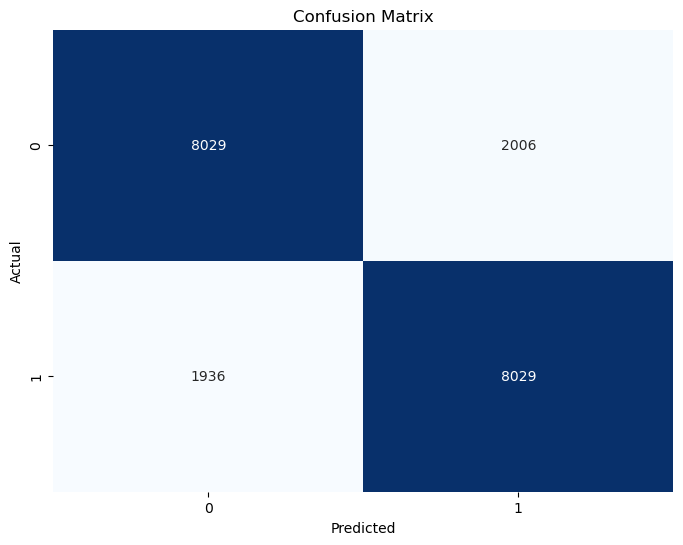

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.80      0.80     10035
           2       0.80      0.81      0.80      9965

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



In [38]:
# clf_perceptron_bow = Perceptron(tol=1e-3, random_state=0)
precision_perceptron_bow, recall_perceptron_bow, f1_perceptron_bow = train_funct(clf_perceptron, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

In [39]:
results_df_perceptron = get_results_df(clf_perceptron, 
                   precision_perceptron_tfidf, recall_perceptron_tfidf, f1_perceptron_tfidf, 
                   precision_perceptron_bow, recall_perceptron_bow, f1_perceptron_bow)

display(results_df_perceptron)

0.8029196712909734 0.8029 0.8029
0.7904536478794268 0.79 0.7898975538817528


,Algorithm,Approach,Precision,Recall,F1-Score
0,Perceptron,BoW,0.802920,0.8029,0.802900
1,Perceptron,TF-IDF,0.790454,0.7900,0.789898


# 6. SVM
## (i) BoW

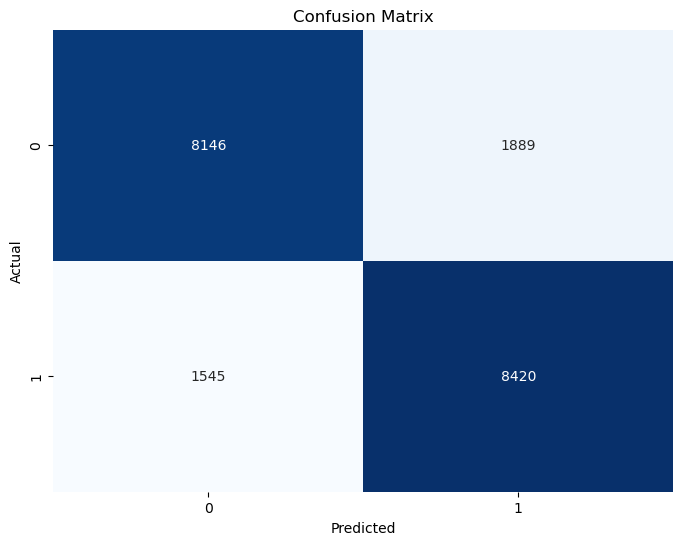

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.81      0.83     10035
           2       0.82      0.84      0.83      9965

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



In [31]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_svm = LinearSVC(dual=True, random_state=0, tol=1e-5, max_iter=100000)
precision_svm_bow, recall_svm_bow, f1_svm_bow = train_funct(clf_svm, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

## (ii) TF-IDF

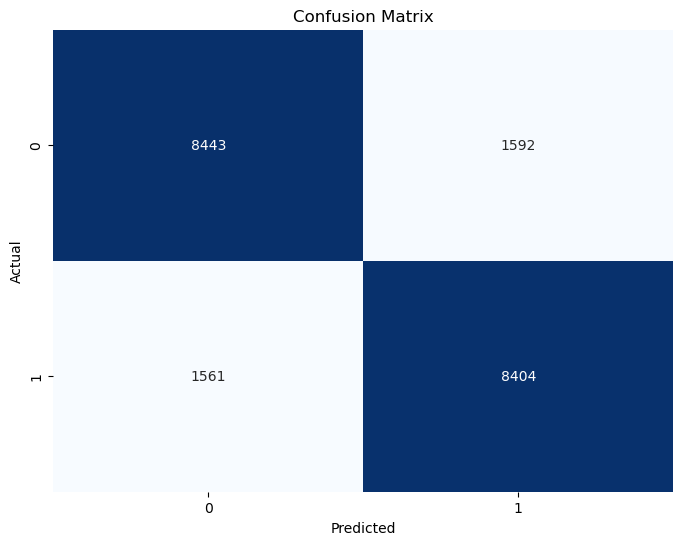

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.84      0.84     10035
           2       0.84      0.84      0.84      9965

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



In [32]:
precision_svm_tfidf, recall_svm_tfidf, f1_svm_tfidf = train_funct(clf_svm, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)

In [44]:
results_df_svm = get_results_df(clf_svm, 
                                precision_svm_tfidf, recall_svm_tfidf, f1_svm_tfidf,
                               precision_svm_bow, recall_svm_bow, f1_svm_bow)

display(results_df_svm)

0.840573728201424 0.8117588440458395 0.8259150359931055
0.8439624150339864 0.8413552566018934 0.8426568192025551


,Algorithm,Approach,Precision,Recall,F1-Score
0,LinearSVC,BoW,0.840574,0.811759,0.825915
1,LinearSVC,TF-IDF,0.843962,0.841355,0.842657


# 7. Logistic Regression
## (i) BoW

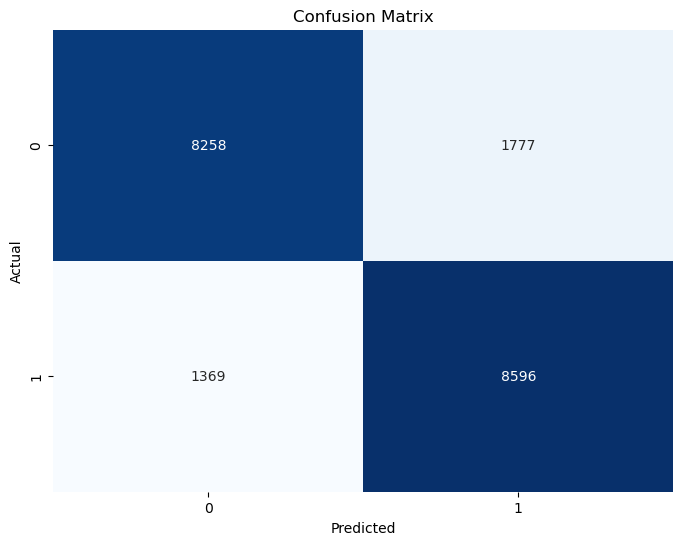

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.82      0.84     10035
           2       0.83      0.86      0.85      9965

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



In [34]:
clf_lr = LogisticRegression(random_state=0)
precision_lr_bow, recall_lr_bow, f1_lr_bow = train_funct(clf_lr, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

## (ii) TF-IDF

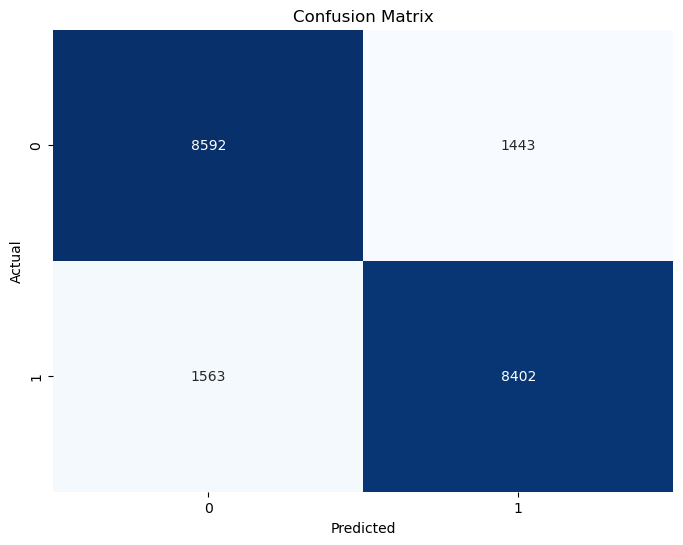

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.86      0.85     10035
           2       0.85      0.84      0.85      9965

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



In [35]:
precision_lr_tfidf, recall_lr_tfidf, f1_lr_tfidf = train_funct(clf_lr, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)

In [45]:
results_df_lr = get_results_df(clf_lr, 
                                precision_lr_tfidf, recall_lr_tfidf, f1_lr_tfidf,
                               precision_lr_bow, recall_lr_bow, f1_lr_bow)

display(results_df_lr)

0.8577957826945051 0.8229197807673144 0.8399959312379208
0.8460856720827179 0.856203288490284 0.8511144130757802


,Algorithm,Approach,Precision,Recall,F1-Score
0,LogisticRegression,BoW,0.857796,0.822920,0.839996
1,LogisticRegression,TF-IDF,0.846086,0.856203,0.851114


# 8. Naive Bayes
## (i) BoW

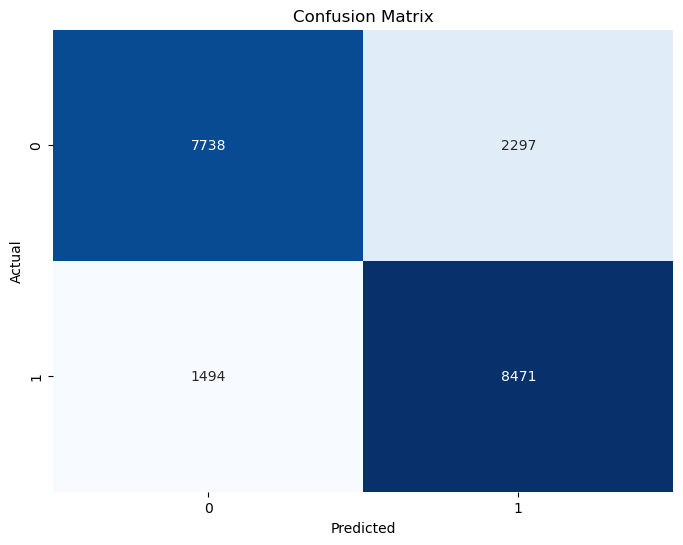

Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.77      0.80     10035
           2       0.79      0.85      0.82      9965

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



In [37]:
clf_nb = MultinomialNB()
precision_nb_bow, recall_nb_bow, f1_nb_bow = train_funct(clf_nb, X_train_bow.toarray(), y_train_bow, X_test_bow.toarray(), y_test_bow)

## (ii) TF-IDF

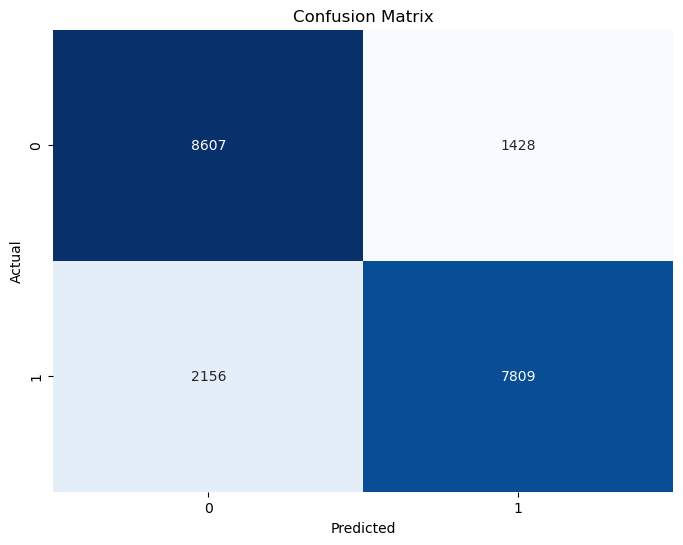

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.86      0.83     10035
           2       0.85      0.78      0.81      9965

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000



In [38]:
precision_nb_tfidf, recall_nb_tfidf, f1_nb_tfidf = train_funct(clf_nb, X_train_tfidf.toarray(), y_train_tfidf, X_test_tfidf.toarray(), y_test_tfidf)

In [46]:
results_df_nb = get_results_df(clf_nb, 
                                precision_nb_tfidf, recall_nb_tfidf, f1_nb_tfidf,
                               precision_nb_bow, recall_nb_bow, f1_nb_bow)

display(results_df_nb)

0.8381715771230502 0.7711011459890383 0.803238698292417
0.7996841029452755 0.8576980568011958 0.8276757380517357


,Algorithm,Approach,Precision,Recall,F1-Score
0,MultinomialNB,BoW,0.838172,0.771101,0.803239
1,MultinomialNB,TF-IDF,0.799684,0.857698,0.827676


In [40]:
dataframes_to_merge = [results_df_perceptron, results_df_svm, results_df_lr, results_df_nb]

# Concatenate the DataFrames along rows (axis=0)
merged_df = pd.concat(dataframes_to_merge, ignore_index=True)
merged_df = merged_df.set_index("Algorithm")
# Display the merged DataFrame
display(merged_df)

,Approach,Precision,Recall,F1-Score
Algorithm,,,,
Perceptron,BoW,0.805720,0.800100,0.802900
Perceptron,TF-IDF,0.779374,0.811061,0.794902
LinearSVC,BoW,0.840574,0.811759,0.825915
LinearSVC,TF-IDF,0.843962,0.841355,0.842657
LogisticRegression,BoW,0.857796,0.822920,0.839996
LogisticRegression,TF-IDF,0.846086,0.856203,0.851114
MultinomialNB,BoW,0.838172,0.771101,0.803239
MultinomialNB,TF-IDF,0.799684,0.857698,0.827676


In [41]:
# Average length of reviews before and after data cleaning
print(f"{avg_length_nopreprocessing}, {avg_length_clean}")

# Average length of reviews before and after data preprocessing
print(f'{df_50k[["review_body_length", "review_body_cleaned_length", "review_body_lemm_processed_length"]].describe().iloc[1].values[1]},'
      f'{df_50k[["review_body_length", "review_body_cleaned_length", "review_body_lemm_processed_length"]].describe().iloc[1].values[2]}')
#Precision, Recall, and f1-score
for i in range(merged_df.shape[0]):
    if merged_df.iloc[i]['Approach']=='BoW':
        print(f"{merged_df.iloc[i]['Precision']} {merged_df.iloc[i]['Recall']} {merged_df.iloc[i]['F1-Score']}")
    elif merged_df.iloc[i]['Approach']=='TF-IDF':
        print(f"{merged_df.iloc[i]['Precision']} {merged_df.iloc[i]['Recall']} {merged_df.iloc[i]['F1-Score']}")

317.59742, 300.86103
57.03143,28.81422
0.8057200200702459 0.8000996512207275 0.8029000000000001
0.779373743177248 0.8110612855007474 0.7949018458833871
0.840573728201424 0.8117588440458395 0.8259150359931055
0.8439624150339864 0.8413552566018934 0.8426568192025551
0.8577957826945051 0.8229197807673144 0.8399959312379208
0.8460856720827179 0.856203288490284 0.8511144130757802
0.8381715771230502 0.7711011459890383 0.803238698292417
0.7996841029452755 0.8576980568011958 0.8276757380517357


# References

* [TfidfVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [CountVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [train_test_split Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [Perceptron Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)
* [SVC Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
